#### This script should be used for one station at a time. Change the below cell before running on a new station

This script pulls in aligned, stacked tifs (run Create_aligned_tifs.ipynb beforehand) and calculates mean Lsky, Lt, Ed, Trs. It masks Trs and solves for Rrs using the NIR pixel assumption. A chl algorithm is applied and georeferenced chl tifs are exported.  


In [1]:
from micasense import imageset as imageset
from micasense import capture as capture
from micasense import image as image
import micasense.metadata as metadata
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import exiftool
import datetime
import subprocess
import pandas as pd
import rasterio
import copy
import xarray as xr

In [2]:
station_data = pd.read_excel(os.path.join('S:/', 'Micasense_WQ', 'station_data.xlsx'), index_col=False)
i=0

date = station_data['Date'][i]
station = station_data['Site'][i]
mica_dir = station_data['MicaSense dir'][i]
imagePath = os.path.join('S:/', 'Micasense_WQ', date, mica_dir , '000')
wind_idx = station_data['Wind idx'][i]
cloud_idx = station_data['Cloud idx'][i]
print(station)
print(imagePath)

CB4.2E
S:/Micasense_WQ\09_16_20\0000SET\000


### Declare zenith angle from MicaSense metadata

In [3]:
#load zenith angle, wind, cloud 
metadata = pd.read_csv(os.path.join(imagePath, 'flight_stacks', 'log.csv'), index_col=False)
time = metadata['GPSTimeStamp'][15] # UTC time at middle capture
print(time)
mica_elevationangle = (metadata['SolarElevation'].mean())*180/np.pi
print(mica_elevationangle)
mica_zenith = 90-mica_elevationangle
print(mica_zenith)
zenith_range = (0, 10, 20, 30, 40, 50, 60)
zenith_idx = (np.abs(zenith_range-mica_zenith)).argmin()

#print LUT indices for zenith angle, wind, and cloud parameters
print(zenith_idx, wind_idx, cloud_idx)

16:38:13
53.29935222133528
36.70064777866472
4 1 0


### Derive mean Lsky radiance for each band

C:\Users\Anna\Anaconda3\envs\micasense\lib\site-packages\rasterio\__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[105.80492159  92.84680295  65.90189121  51.72029067  35.14568252]


Text(0.5, 1.0, 'Lsky')

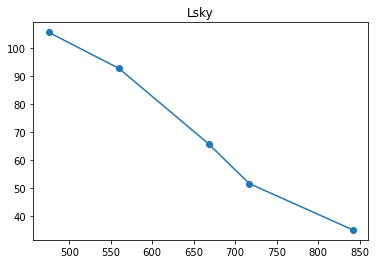

In [4]:
#Declare Lsky and average across stations
Lsky = []
for im in glob.glob(os.path.join(imagePath, 'Lsky_stacks')+ "/*.tif"):
    with rasterio.open(im, 'r') as src:
        Lsky.append(src.read())
Lsky = np.array(Lsky) / 32768 * 1000 # Scale to Radiance (mW )

# Average Lsky Spectra
Lsky_mean = np.mean(Lsky, axis=(0,2,3))
Lsky_sd = np.std(Lsky, axis=(0,2,3))
print(Lsky_mean)

#plot Lsky spectra
wv = [475, 560, 668, 717, 842]
plt.plot(wv, Lsky_mean,  marker = 'o')
plt.title('Lsky')

### Derive mean Ed values for each band and image

[1092.01547817 1000.75122117  881.50146617  683.33450236  547.974948  ]
(30, 5)


Text(0.5, 1.0, 'Flight Ed')

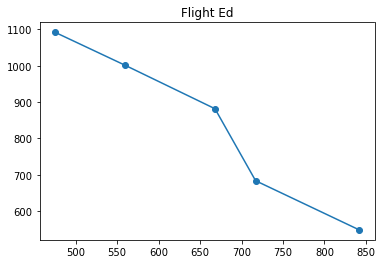

In [5]:
#pull in Ed csv and average across stations
all_Ed = pd.read_csv(os.path.join(imagePath, 'Ed_data.csv')).drop('timestamp', axis=1).to_numpy()
Ed_mean =  np.mean(all_Ed, axis=0)
Ed_sd =  np.std(all_Ed, axis=0)
print(Ed_mean)
print(all_Ed.shape)

#plot Ed spectra
plt.plot(wv, Ed_mean,  marker = 'o')
plt.title('Flight Ed')

### Derive mean Lt for flight captures

C:\Users\Anna\Anaconda3\envs\micasense\lib\site-packages\rasterio\__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(30, 5, 923, 1219)
(923, 1219, 30, 5)
[ 9.19845884 11.58385932  6.91360471  4.95143365  3.1913571 ]


Text(0.5, 1.0, 'Flight Lt')

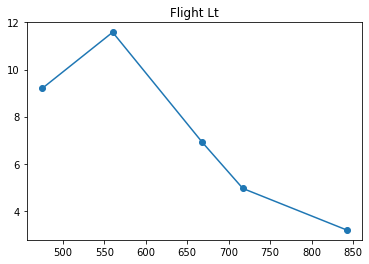

In [6]:
#Decalre Lt and average across stations
Lt = []
for im in glob.glob(os.path.join(imagePath,'flight_stacks')+ "/*.tif"):
    with rasterio.open(im, 'r') as src:
        Lt.append(src.read())        
Lt = np.array(Lt) / 32768 * 1000 # Scale to Radiance (mW)
print(Lt.shape)

# Need to reorder Lt axis so we can divide by all_Ed
# for np.divide to properly 'broadcast' https://numpy.org/doc/stable/user/basics.broadcasting.html
Lt = np.moveaxis(Lt, 0, -1)
Lt = np.moveaxis(Lt, 0, -1)
print(Lt.shape)

Lt_mean =  np.mean(Lt, axis=(0,1,2))
Lt_sd =  np.std(Lt, axis=(0,1,2))
print(Lt_mean)

#plot Lt spectra
plt.plot(wv, Lt_mean,  marker = 'o')
plt.title('Flight Lt')

### Get rho LUT values for zenith, wind, and cloud parameters

(5, 6, 6, 7)
[0.02312573 0.02314093 0.02316027 0.02316909 0.02319064]
[0.99720086 0.99785636 0.99869033 0.99907075 1.        ]


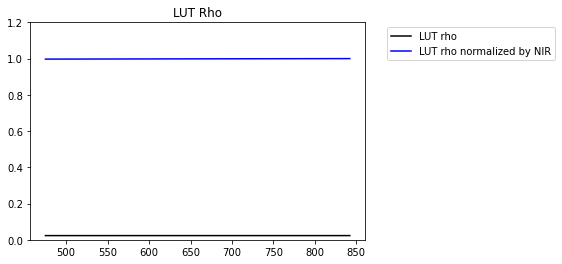

In [7]:
#pull in rho LUT
rho_lut = xr.open_dataarray("S:/MicaSense_WQ/R/rho_lut3.nc")
print(rho_lut.shape) #wv, cloud, wind, zenith 

#Declare rho based on cloud, wind, zenith angle 
lut_rho = rho_lut[:, cloud_idx, wind_idx, zenith_idx].values
print(lut_rho)

#plot rho spectra
plt.plot(wv, lut_rho, color='black', label = 'LUT rho')
plt.title("LUT Rho")

#normalize by nir band 
lut_rho_norm = lut_rho/lut_rho[4,]
print(lut_rho_norm)
plt.plot(wv, lut_rho_norm, color='blue', label = 'LUT rho normalized by NIR')
plt.ylim(0,1.2)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

### Mask Trs where Trs >  red edge mean(Trs)+sd

0.014151026915886857
[0.0075265  0.0104597  0.00666785 0.00596835 0.00438862]


<Figure size 432x288 with 0 Axes>

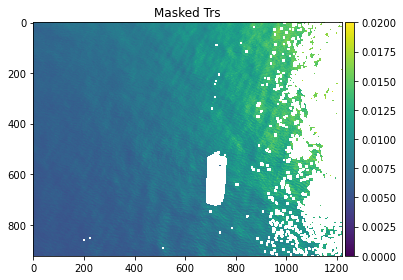

In [8]:
#calculate Trs (Lt/Ed) with masking sun glint
Trs_masked = np.divide(Lt, all_Ed)

#calculate upper limit based on known Rrs, rho and Lsky/Ed in NIR
upper = 0.005 + lut_rho[4] * 0.3946
print(upper)

Trs_masked[:,:,:,4][Trs_masked[:,:,:,4]>upper] = np.nan
Trs_masked[:,:,:,1][Trs_masked[:,:,:,1]<0.007] = np.nan #masking boat canopy
nan_index = np.isnan(Trs_masked)

#mask pixels in all bands according to nan_index
for i in range(5):
    Trs_masked[:,:,:,i][nan_index[:,:,:,4]] = np.nan
    Trs_masked[:,:,:,i][nan_index[:,:,:,1]] = np.nan

Trs_masked_mean =  np.nanmean(Trs_masked, axis=(0,1,2))
Trs_masked_sd =  np.nanstd(Trs_masked, axis=(0,1,2))
print(Trs_masked_mean)
    
#plotting example image of masked R
plt.figure(1)
fig, axis = plotutils.plotwithcolorbar(Trs_masked[:,:,16,0], title='Masked Trs', vmin=0, vmax=.02)
#fig.savefig(os.path.join('S:/', 'Micasense_WQ', 'Figures','masked_example.png'))
del Lt

### NIR pixel Rrs 
#### Predicting NIR value from blue/rededge ratio vs Trios Rrs(nir) 

1.2992927767737819
0.00016702827034189183
0.0658507193510255
[0.00114917 0.00435331 0.00174699 0.0009867  0.00016703]


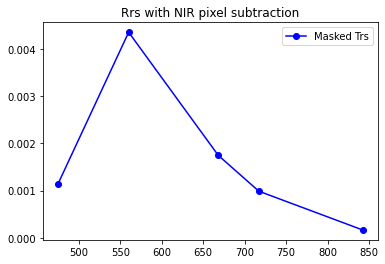

In [9]:
#exp function from R
blue_re_ratio = Trs_masked[:,:,:,0]/Trs_masked[:,:,:,3]

blue_re_ratio[blue_re_ratio == 0] = 'nan' #setting 0 to nans because was getting divide by 0 error
print(np.nanmean(blue_re_ratio))
nir_predict = 0.02564*np.exp(blue_re_ratio * -5.469) + 0.00013
print(np.nanmean(nir_predict))

rho_predict = (all_Ed[:,4]/Lsky_mean[4]) * (Trs_masked[:,:,:,4] - nir_predict)
print(np.nanmean(rho_predict))

#create an array with 5 dimensions having same rho values
nir_pixel_array = np.concatenate((rho_predict[:,:,:,np.newaxis], rho_predict[:,:,:,np.newaxis], rho_predict[:,:,:,np.newaxis], \
                      rho_predict[:,:,:,np.newaxis], rho_predict[:,:,:,np.newaxis]), axis=3)

#using masked Trs
Rrs_nirpixel_masked = Trs_masked - nir_pixel_array*Lsky_mean/all_Ed
Rrs_nirpixel_masked_mean = np.nanmean(Rrs_nirpixel_masked, axis=(0,1,2))
Rrs_nirpixel_masked_sd = np.nanstd(Rrs_nirpixel_masked, axis=(0,1,2))
print(Rrs_nirpixel_masked_mean)

#plot Rrs 
plt.plot(wv, Rrs_nirpixel_masked_mean,  marker = 'o', color='blue', label = 'Masked Trs')
plt.legend()
plt.title('Rrs with NIR pixel subtraction')

del rho_predict, nir_pixel_array

### Hedley deglinting methods

(32485194, 5)
[1.40151998 1.50375024 1.40621297 1.38229368 1.        ]
[0.00406167 0.00674214 0.00319142 0.00255106 0.00191643]


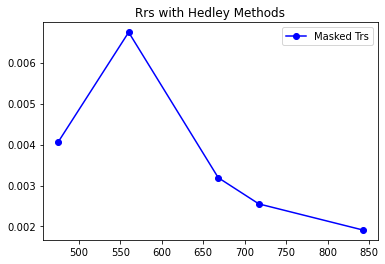

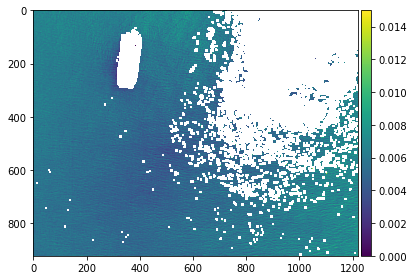

In [10]:
#decalre minimum Trs(NIR) value (doing this before getting rid of nans)
min_Trs_masked = np.nanpercentile(Trs_masked[:,:,:,4], .1)

#find the indices of non nans and make array of those
no_nan_idx = np.isfinite(Trs_masked[:,:,:,0])
no_nan_Trs_masked = Trs_masked[no_nan_idx]
print(no_nan_Trs_masked.shape)

#get slopes between NIR and visible bands
blue_m, blue_b = np.polyfit(no_nan_Trs_masked[:,4], no_nan_Trs_masked[:,0], 1)
green_m, green_b = np.polyfit(no_nan_Trs_masked[:,4], no_nan_Trs_masked[:,1], 1)
red_m, red_b = np.polyfit(no_nan_Trs_masked[:,4], no_nan_Trs_masked[:,2], 1)
rededge_m, rededge_b = np.polyfit(no_nan_Trs_masked[:,4], no_nan_Trs_masked[:,3], 1)
nir_m, nir_b = np.polyfit(no_nan_Trs_masked[:,4], no_nan_Trs_masked[:,4], 1)
slopes = np.array([blue_m, green_m, red_m, rededge_m, nir_m])
print(slopes)

#using masked Trs
Rrs_Hedley_masked = np.zeros((923,1219,30,5))
for i in range(5):
    Rrs_Hedley_masked[:,:,:,i] = Trs_masked[:,:,:,i] - slopes[i]*(Trs_masked[:,:,:,4]-min_Trs_masked)
Rrs_Hedley_masked_mean = np.nanmean(Rrs_Hedley_masked, axis=(0,1,2))
Rrs_Hedley_masked_sd = np.nanstd(Rrs_Hedley_masked, axis=(0,1,2))
print(Rrs_Hedley_masked_mean)

#plot Rrs 
plt.plot(wv, Rrs_Hedley_masked_mean,  marker = 'o', color='blue', label = 'Masked Trs')
plt.legend()
plt.title('Rrs with Hedley Methods')

fig, axis = plotutils.plotwithcolorbar(Rrs_Hedley_masked[:,:,5,1], title='', vmin=0, vmax=.015)
#fig.savefig(os.path.join('S:/', 'Micasense_WQ', 'Figures','Rrs_Hedley.tif') , dpi=300, format="tiff")

del Trs_masked 

### Apply Chlorophyll algorithm

[[14.12591348 14.80333799 10.58894631 ...         nan         nan
          nan]
 [13.38600908 12.71181901 12.54141286 ...         nan         nan
          nan]
 [10.8508385  15.75996902 10.86519348 ...         nan         nan
          nan]
 ...
 [ 7.3260054   3.54552409  7.24309484 ... 10.23180681  2.63712217
   4.0779495 ]
 [12.83672015  7.97656538  6.83374648 ... -4.59923364  9.96623549
  13.20301693]
 [ 8.92303956  0.9655815   6.5119614  ... -2.31936958  2.27212301
  10.20257352]]


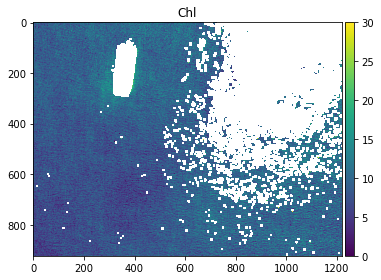

In [11]:
chl = 24.018 + Rrs_nirpixel_masked[:,:,:,1]*-4337.878 + Rrs_nirpixel_masked[:,:,:,3]*9639.746 + Rrs_nirpixel_masked[:,:,:,4]*-29222.799
print(chl[:,:,5])
fig, axis = plotutils.plotwithcolorbar(chl[:,:,5], title='Chl', vmin=0, vmax=30)

min_chl = np.nanmin(chl)
max_chl = np.nanmax(chl)
mean_chl = np.nanmean(chl)
sd_chl = np.nanstd(chl)

### Apply TSS Algorithm

In [ ]:
TSS = 30.56802 + Rrs_Hedley_masked[:,:,:,0]*1364.86038 + Rrs_Hedley_masked[:,:,:,2]*-5255.87676 + Rrs_Hedley_masked[:,:,:,3]*2548.08212 + Rrs_Hedley_masked[:,:,:,4]*4579.36078
print(TSS[:,:,5])
fig, axis = plotutils.plotwithcolorbar(TSS[:,:,5], title='TSS', vmin=0, vmax=60)

min_TSS = np.nanmin(TSS)
max_TSS = np.nanmax(TSS)
mean_TSS = np.nanmean(TSS)
sd_TSS = np.nanstd(TSS)

In [ ]:
d = {'min_chl': min_chl, 'max_chl': max_chl, 'mean_chl': mean_chl, 'sd_chl': sd_chl, \
    'min_TSS': min_TSS, 'max_TSS': max_TSS, 'mean_TSS': mean_TSS, 'sd_TSS': sd_TSS}

print(d)

station_data = pd.DataFrame(d, index=[0])
print(station_data)
station_data.to_csv(os.path.join('S:/', 'Micasense_WQ', date, station + '_chlTSS.csv'), index=False, header=True)


### Georeference and export tifs

In [ ]:
for n in range(30):
    log = pd.read_csv(os.path.join(imagePath, 'flight_stacks', 'log.csv'), index_col=False)

    # open the original image
    src = rasterio.open(os.path.join(imagePath, "georeferenced_stacks", log['ID'][n]))

    # Register GDAL format drivers and configuration options with a
    # context manager.
    with rasterio.Env():

        # Write an array as a raster band to a new 8-bit file. For
        # the new file's profile, we start with the profile of the source
        profile = src.profile

        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=rasterio.float64,
            count=1,
            compress='lzw')

        with rasterio.open(os.path.join(imagePath, "georeferenced_stacks", 'chl_' + log['ID'][n]), 'w', **profile) as dst:
            dst.write(chl[:,:,n].astype(rasterio.float64), 1)
            
        with rasterio.open(os.path.join(imagePath, "georeferenced_stacks", 'TSS_' + log['ID'][n]), 'w', **profile) as dst:
            dst.write(TSS[:,:,n].astype(rasterio.float64), 1)

    # At the end of the ``with rasterio.Env()`` block, context
    # manager exits and all drivers are de-registered.
